In [1]:
# Data manipulation
import numpy as np 
import pandas as pd 
from PIL import Image

# Data Vis
import matplotlib.pyplot as plt

# Text manipulation
from string import punctuation
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# NLP Module
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk import word_tokenize,sent_tokenize
from nltk import WordNetLemmatizer

from nltk.stem.porter import *
from nltk.stem.lancaster import *
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [2]:
from pandas_profiling import ProfileReport

In [3]:
# Path of folders where data are stored
DATA_PATH = "data/"
FIG_PATH = "fig/"

# Hands ON 1

## Load Data

In [4]:
# Try to name your data / dataframe explicitly. 
file_name = "raw_scrapped_data.csv.gzip"
file_path = DATA_PATH + file_name

# Reading data
scrapped_data = pd.read_csv(file_path, compression='gzip')

In [5]:
# scrapped_data = pd.read_json(DATA_PATH + "scrapped_data", lines=True)

# import json_lines
# json_data = []
# with open(DATA_PATH + "raw_review_london.jl", 'rb') as f:
#     reader = json_lines.reader(f)
#     for line in reader:
#         try:
#             json_data.append(line)
#         except:
#             pass
        
# scrapped_data = pd.DataFrame.from_records(json_data)
# print(scrapped_data.shape)

In [6]:
# Take only a limited number of our reviews to increase speed / reduce process time
# You may want to start with low number of rows to see if your code works, and then increase this number to perform
# relevant and global analysis

# With sample you can specify a raw value of number of rows you want 
# scrapped_data = scrapped_data.sample(30000)

# Or you can specify a fraction of initial rows
# scrapped_data = scrapped_data.sample(frac=0.1)

## Explore Data

In [7]:
scrapped_data.sample()

,id_resto,id_comment,resto,resto_url,rating,title,diner_date,rating_date,answer_text,reviewer_pseudo,reviewer_origin,reviewer_info_sup,other_ratings_category,other_ratings_value,url,content
39935,g186338-d2587658,g186338-d2587658-r613093937,Mele_e_Pere,/Restaurant_Review-g186338-d2587658-Reviews-Me...,3,Average,August 2018,"September 2, 2018",NaN,beatriceuk90,[],"[['pencil-paper', '5'], ['thumbs-up-fill', '6']]",[],[],https://www.tripadvisor.com/ShowUserReviews-g1...,['Food was okay and really good atmosphere but...


## Feature Engineering

In [8]:
# Create useful columns/features
data = pd.DataFrame()

In [9]:
data['day_of_week'] = pd.to_datetime(scrapped_data['rating_date']).dt.weekday

In [10]:
data['len_review'] = scrapped_data.content.apply(len)

In [11]:
data['content'] = scrapped_data.content

In [12]:
data['content'] = scrapped_data['content'].apply(lambda x: "".join(x))

In [13]:
data['rating'] = scrapped_data.rating

In [16]:
data.head()

,day_of_week,len_review,content,rating
0,0,634,['Decided to visit Windsor castle on the way b...,5
1,6,185,['The food was very good (although rather smal...,2
2,2,784,['When looking for somewhere in budget to go a...,5
3,3,401,['Good menu selection. Unfortunately had no st...,4
4,5,392,['We popped in here last night for a glass of ...,3


## Some visualisations

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

In [21]:
# What do you want to observe quickly ? 

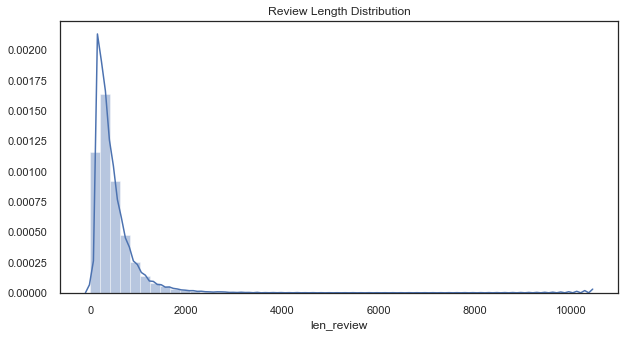

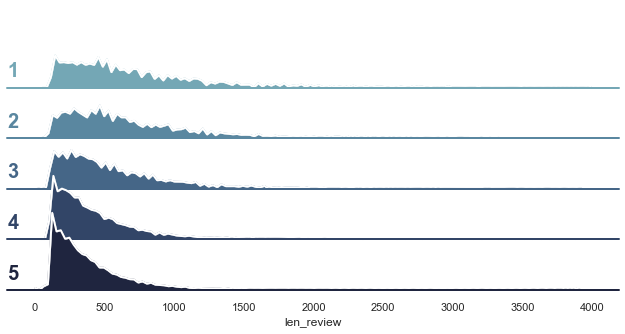

In [30]:
## Review Length Distribution
fig, axs = plt.subplots(figsize=(10,5))
sns.distplot(data.len_review);
axs.set_title('Review Length Distribution');


## Review Length Distribution (w.r.t. rating)
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(5, rot=-.25, light=.6)
g = sns.FacetGrid(data[data.len_review<4000], row="rating", hue="rating", aspect=9.5, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "len_review", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "len_review", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", fontsize=20, color=color, ha="left", va="center", transform=ax.transAxes)
g.map(label, "len_review")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace = -0.375)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True);

## Work on reviews

### Preprocessing

In [71]:
reviews = data['content'].tolist()

In [72]:
reviews[4]

"['We popped in here last night for a glass of wine, before attending the theatre nearby.', 'It was a fairly busy Friday night but the service was reasonably quick, but not overly friendly service from behind the bar.', 'The Fitout was tired and there were aspects that indicated maintenance/upkeep are not a priority, but it was convenient. That’s probably the best that I can say about it.']"

In [73]:
# Homework function #1 
def basic_cleaning(rev, stemming="porter"):
    """
    NOTE:
    """
    # Normalize case & Remove punctuation
    rev = "".join([c for c in rev if c not in punctuation]).lower()
    # Tokenize review
    rev = word_tokenize(rev)
    # Remove Stopwords
    rev = [w for w in rev if not w in set(stopwords.words('english'))]
    # Lemmatize Review
    stemmer = {"porter": PorterStemmer(), 
                   "snowball": SnowballStemmer("english"), 
                   "lancaster": LancasterStemmer()}
    try:
        rev = [stemmer[stemming].stem(wd) for wd in rev]
        return rev
    
    except:
        return rev

In [ ]:
data.content = data.content.apply(basic_cleaning)

In [ ]:
data

## Data Vizualisation
### Wordclouds

In [ ]:
# Define a mask for wordcloud
image = Image.open(FIG_PATH + "plate.jpg")
plate_mask = np.array(image)

In [149]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=50,
        max_font_size=40,
        scale=3,
        random_state=1  # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

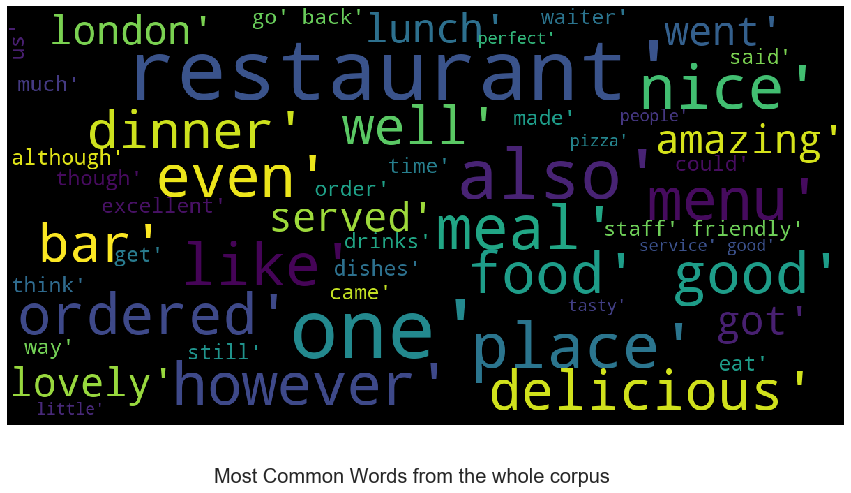

In [150]:
show_wordcloud(tokens_filtered, 'Most Common Words from the whole corpus')

## Function from corpus to wordcloud

In [84]:
# Homework function 2 
def from_corpus_to_word_cloud(reviews):
    ## Basic Cleaning (Punctuation+Uppercase)
    
    
    ## Tokenize Reviews
    
    
    ## Remove Stopwords
    
    
    ## Lemmatization/Stemming
    
    
    ## Generate WordCloud
    
    
    return

# Homeworks

For homework you are asked to code 2 functions : 
- A function that do the basic cleaning of a corpus
- A function that creates a wordcloud from a cleaned corpus

Bonus : Be creative about text visualisations, and on how to get relevant insights from your reviews